# Softmax demo

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
import random
import numpy as np
from models_utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

In [6]:

from models_utils.classifiers.softmax import softmax_loss_simple
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_simple(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.324150
sanity check: 2.302585


Why -log(0.1)? That's because when weights are initialized, every class has similar probabilities. Hence for 10 classes, L = -log(1/10)

In [9]:
# Complete the implementation of softmax_loss_simple and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_simple(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from models_utils.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_simple(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

loss, grad = softmax_loss_simple(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_simple(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.168588 analytic: -1.168588, relative error: 2.789112e-08
numerical: -1.626157 analytic: -1.626157, relative error: 8.645990e-10
numerical: 0.320138 analytic: 0.320138, relative error: 1.871974e-07
numerical: -1.278192 analytic: -1.278192, relative error: 1.586986e-08
numerical: 2.695576 analytic: 2.695576, relative error: 3.425988e-09
numerical: -1.533833 analytic: -1.533833, relative error: 7.615919e-10
numerical: 0.865136 analytic: 0.865136, relative error: 9.823417e-08
numerical: -0.203923 analytic: -0.203923, relative error: 2.193741e-07
numerical: 2.783726 analytic: 2.783726, relative error: 1.282184e-08
numerical: -2.482758 analytic: -2.482758, relative error: 8.522865e-09
numerical: 1.125161 analytic: 1.125161, relative error: 4.718220e-09
numerical: 0.178969 analytic: 0.178969, relative error: 1.517791e-07
numerical: 2.004870 analytic: 2.004870, relative error: 1.419183e-08
numerical: -0.277062 analytic: -0.277062, relative error: 8.103363e-08
numerical: -0.689748

In [11]:
# Vectorized Solution
tic = time.time()
loss_naive, grad_naive = softmax_loss_simple(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from models_utils.classifiers.softmax import softmax_loss_fast
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_fast(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.324150e+00 computed in 0.193362s
vectorized loss: 2.324150e+00 computed in 0.010721s
Loss difference: 0.000000
Gradient difference: 0.000000


In [12]:
# Grid Search

from models_utils.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-5, 5e-6, 1e-6]
regularization_strengths = [10,5,1,0.5]

for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        cv_softmax = Softmax()
        loss_hist = cv_softmax.train(X_train, y_train, learning_rate=learning_rate, 
                              reg=regularization_strength,
                              num_iters= 1000, verbose=False)
        y_train_pred = cv_softmax.predict(X_train)
        y_val_pred   = cv_softmax.predict(X_val)
        train_accuracy = np.mean(y_train_pred == y_train)
        cv_accuracy = np.mean(y_val_pred == y_val)
        
        results[(learning_rate, regularization_strength)] = (train_accuracy,cv_accuracy)
        
        if cv_accuracy > best_val:
            best_val = cv_accuracy
            best_softmax = cv_softmax
            best_params = (learning_rate, regularization_strength)

    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-06 reg 5.000000e-01 train accuracy: 0.328898 val accuracy: 0.331000
lr 1.000000e-06 reg 1.000000e+00 train accuracy: 0.326265 val accuracy: 0.320000
lr 1.000000e-06 reg 5.000000e+00 train accuracy: 0.333082 val accuracy: 0.304000
lr 1.000000e-06 reg 1.000000e+01 train accuracy: 0.326918 val accuracy: 0.323000
lr 5.000000e-06 reg 5.000000e-01 train accuracy: 0.384939 val accuracy: 0.373000
lr 5.000000e-06 reg 1.000000e+00 train accuracy: 0.363469 val accuracy: 0.350000
lr 5.000000e-06 reg 5.000000e+00 train accuracy: 0.380878 val accuracy: 0.352000
lr 5.000000e-06 reg 1.000000e+01 train accuracy: 0.372367 val accuracy: 0.340000
lr 1.000000e-05 reg 5.000000e-01 train accuracy: 0.351204 val accuracy: 0.325000
lr 1.000000e-05 reg 1.000000e+00 train accuracy: 0.367408 val accuracy: 0.332000
lr 1.000000e-05 reg 5.000000e+00 train accuracy: 0.321510 val accuracy: 0.321000
lr 1.000000e-05 reg 1.000000e+01 train accuracy: 0.328163 val accuracy: 0.323000
best validation accuracy ach

In [15]:
# Train Best SVM further
best_softmax.train(X_train, y_train, learning_rate=best_params[0], reg=best_params[1],
                  num_iters=10000, verbose=False)

[1.8597519245872471,
 1.780416087787837,
 1.6969388463874906,
 1.7275085989387411,
 1.8213777724372344,
 1.7716450473159957,
 1.8947074102127377,
 1.8863196714773132,
 1.7671287391662833,
 1.7335168747850997,
 1.6942011080039521,
 1.5864795610784237,
 1.7611214704018257,
 1.6891038199803929,
 1.6306307891194554,
 1.9009603405064763,
 1.7405653027797328,
 1.669881932983633,
 1.7206216532428042,
 1.6430736150107397,
 1.6700904547795363,
 1.6788500287847792,
 1.7962924604494721,
 1.7860822925743509,
 1.8245592133436488,
 1.6496097101431595,
 1.6530765432926318,
 1.5983623132779852,
 1.7262740057577797,
 1.6406138068650653,
 1.7826953168564859,
 1.8261433833891194,
 1.6442768513465611,
 1.6635176838841941,
 1.5498426000978414,
 1.9077854667684098,
 1.7360433150920742,
 1.9713275723051524,
 1.7660959121812003,
 1.6930508547748799,
 1.8482642893105485,
 1.7074023919344301,
 1.672709047307084,
 1.9372628439070521,
 1.8442331761065514,
 1.7023803196645448,
 1.8745652468627039,
 1.7229500419091

In [17]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.367000


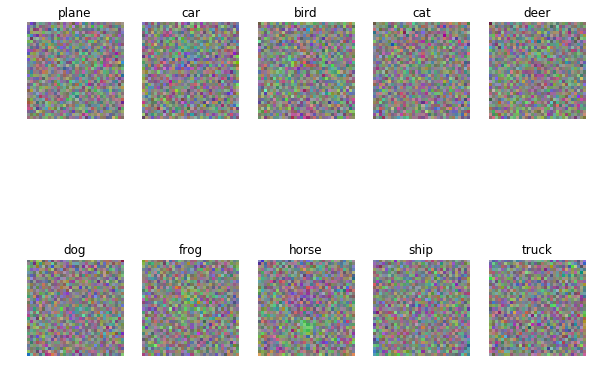

In [18]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])